In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.linear_model import Ridge, Lasso

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from warnings import filterwarnings

filterwarnings('ignore')

%matplotlib inline

sns.set(style="darkgrid")
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

### Disclamer, don't load all the cells at once, it took an hour of real time to calculate one of the cells, there were comparing different models with different settings and including the best alpha, please see the already calculated (if you don't want to wait for an hour).

**Task 1**. We will be working with data from the [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview) competition, which was about predicting the duration of a taxi trip. Download the training sample from this competition and upload it:

In [3]:
train = pd.read_csv('train.csv')

In [4]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


Pay attention to the `pickup_datetime` and `dropoff_datetime` columns. `dropoff_datetime` was added only to the training sample, so, this column cannot be used, let's delete it. `pickup_datetime` contains the date and time the trip started. To make it convenient to work with, let's convert dates to `datetime` objects

In [6]:
train = train.drop('dropoff_datetime', axis=1)
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)

target = 'trip_duration'

The `trip_duration` column contains the target value we want to predict. Let's look at the distribution of the target in the training sample. To do this, draw its histogram:

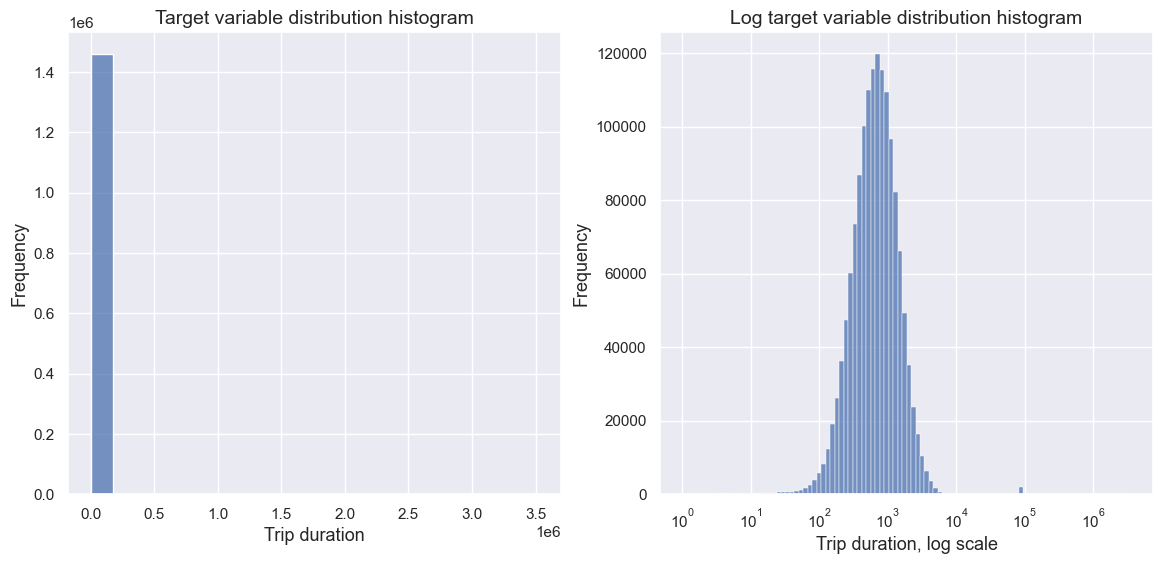

In [7]:
plt.rcParams["figure.figsize"] = (14,6)

fig, ax = plt.subplots(ncols=2)

sns.histplot(data=train, x=target, bins=20, ax=ax[0])
sns.histplot(data=train, x=target, bins=100, ax=ax[1], log_scale=True)

ax[0].set_title('Target variable distribution histogram', dict(size=14))
ax[0].set_xlabel('Trip duration', dict(size=13))
ax[0].set_ylabel('Frequency', dict(size=13))

ax[1].set_title('Log target variable distribution histogram', dict(size=14))
ax[1].set_xlabel('Trip duration, log scale', dict(size=13))
_ = ax[1].set_ylabel('Frequency', dict(size=13))

**Question**: Why is it necessary to build a histogram in a logarithmic scale?

**Answer**

The competition used RMSLE as a quality metric:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Question**: Why do you think the contest authors chose RMSLE and not RMSE?

**Answer**

We have discussed several linear regression models in `sklearn`, but each of them optimized the mean square error (MSE), not RMSLE. Let's do the following trick: we will predict not the target variable, but its *logarithm*. Let $\hat{y}_i = \log{(y_i + 1)}$ be the modified target, and $\hat{a}(x_i)$ be the prediction of the model trained on $\hat{y}_i$, that is, the logarithm of the target. To predict the original value, we can simply take the exponent of our prediction: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

In addition, the logarithm of the target has another useful quality. To see it, add the `log_trip_duration` column to our sample (use `np.log1p`) and draw a histogram of the modified target for the training sample. Delete the column with the old target.

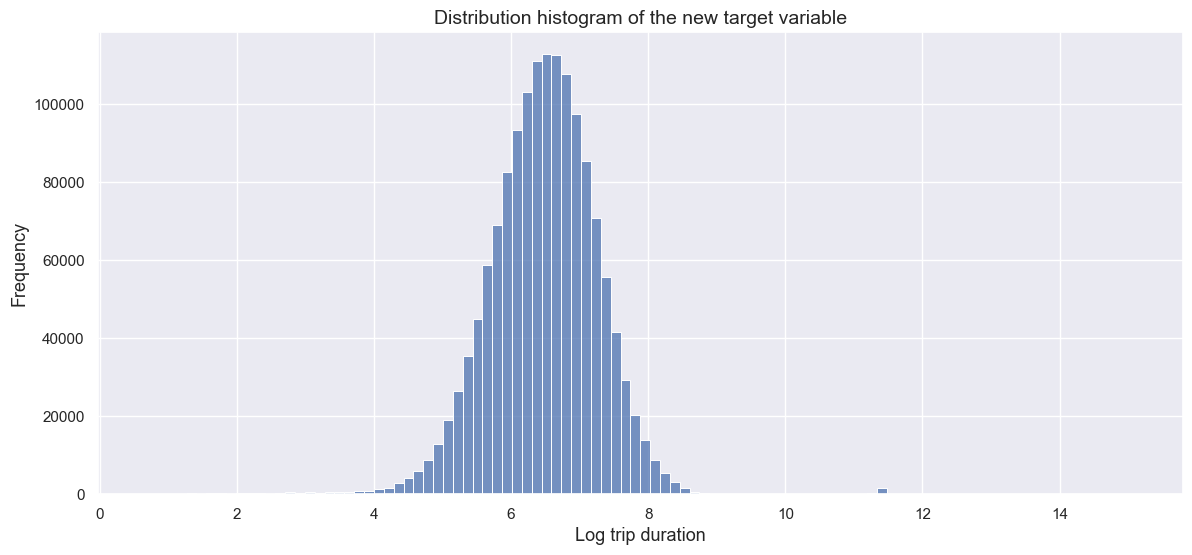

In [8]:
train['log_trip_duration'] = np.log1p(train[target])
train = train.drop('trip_duration', axis=1)
target = 'log_trip_duration'

plt.title('Distribution histogram of the new target variable', dict(size=14))
plt.xlabel('Log trip duration', dict(size=13))
plt.ylabel('Frequency', dict(size=13))
_ = sns.histplot(data=train, x=target, bins=100)

Let's calculate the value of the metric with the best constant prediction:

**Question**: why the best constant for RMSE is mean value?

**Answer**: Because mean value is actually average for vector of data so the sum(y_true - y_pred) will be lower so the rmse will go to 0 then any other values

In [9]:
def RMSE(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean() ** .5

In [10]:
#your code to find constant prediction here:
const_model = train[target].mean()
#end of your code
print('Best constant prediction value: {}'.format(RMSE(train[target], const_model)))

Best constant prediction value: 0.7957592365411509


**Task 2**. First, let's see how many trips there were on each day. Plot the number of trips versus the day of the year:

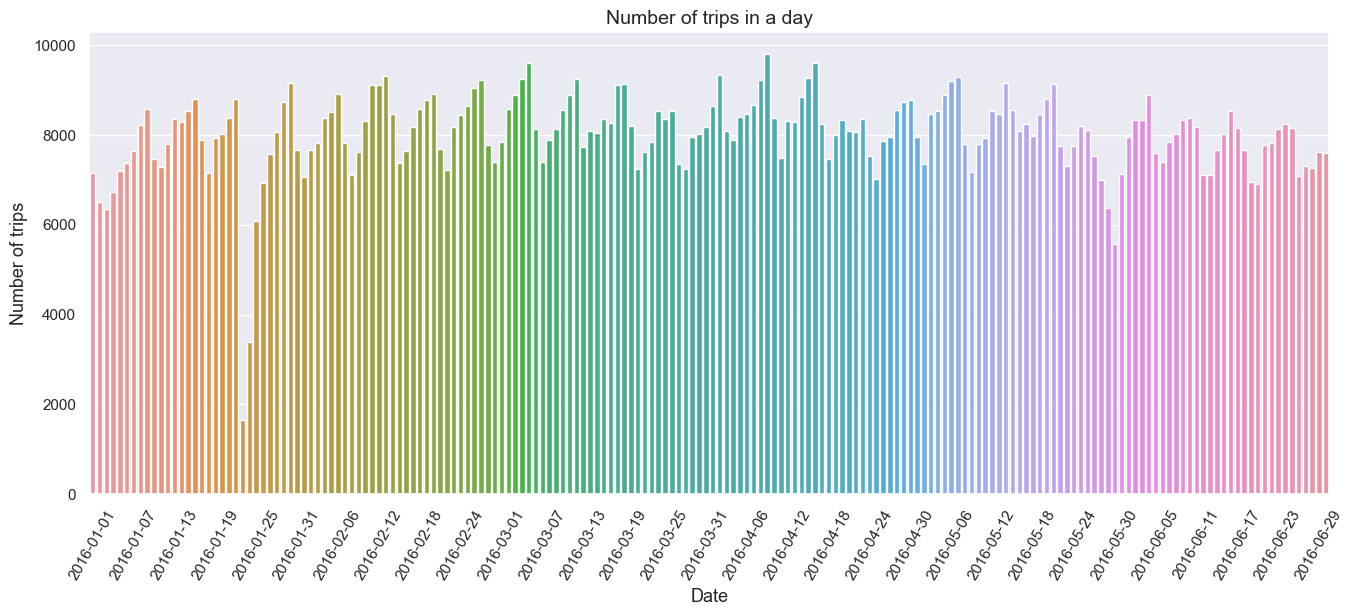

In [11]:
plt.rcParams["figure.figsize"] = (16,6)
train['day_of_year'] = train.pickup_datetime.dt.day_of_year

sns.countplot(x=train['day_of_year'])

plt.title('Number of trips in a day', dict(size=14))
plt.xlabel('Date', dict(size=13))
plt.ylabel('Number of trips', dict(size=13))

_ = plt.xticks(np.arange(0, 181, 6), np.unique(train.pickup_datetime.dt.date)[::6], rotation=60)

**Question**: You may have noticed that there are 2 periods on the graph with abnormally low numbers of trips. Calculate the dates on which these downward swings occurred and find information about what happened on those days in New York.

**Answer**: 20 of january was blizzard. And other date also some kind of teribble meteo conditions



Plot the number of trips versus the day of the week and the hours of the day (use `sns.relplot`):

In [12]:
train['hour'] = train.pickup_datetime.dt.hour
train['day_of_week'] = train.pickup_datetime.dt.day_of_week
train['day_of_year'] = train.pickup_datetime.dt.day_of_year
train['month_name'] = train.pickup_datetime.dt.month_name()

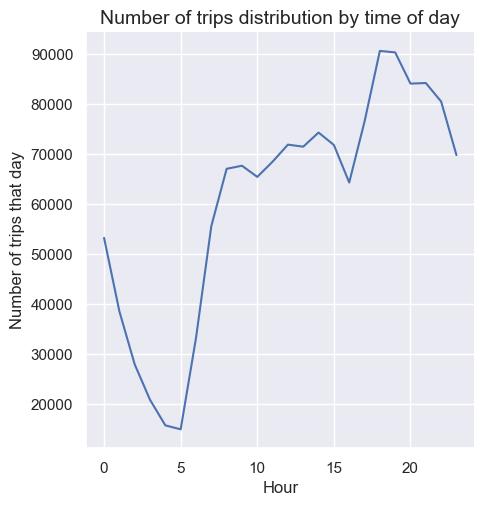

In [13]:
tmp_data = train.groupby('hour').id.count()\
.reset_index().rename({
    'hour': 'Hour',
    'id': 'Number of trips that day'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Hour',
            y='Number of trips that day',
            kind='line')
_ = plt.title('Number of trips distribution by time of day', dict(size=14))

In [14]:
train['day_of_week']

0          0
1          6
2          1
3          2
4          5
          ..
1458639    4
1458640    6
1458641    4
1458642    1
1458643    1
Name: day_of_week, Length: 1458644, dtype: int64

In [15]:
tmp_data

,Hour,Number of trips that day
0,0,53248
1,1,38571
2,2,27972
3,3,20895
4,4,15792
5,5,15002
6,6,33248
7,7,55600
8,8,67053
9,9,67663


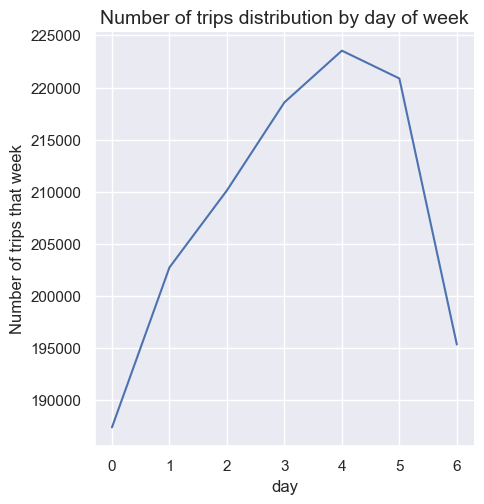

In [16]:
#your code for number of trips distribution by day of week
tmp_data = train.groupby('day_of_week').id.count()\
.reset_index().rename({
    'day_of_week': 'day',
    'id': 'Number of trips that week'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='day',
            y='Number of trips that week',
            kind='line')
_ = plt.title('Number of trips distribution by day of week', dict(size=14))

#end of your code

**Task 3**. Draw on one graph the dependence of the number of trips on the hour of the day for different months (different curves corresponding to different months, color in different colors with use of `hue` in `sns.relplot`). Similarly, draw the dependence of the number of trips on the hour of the day for different days of the week.

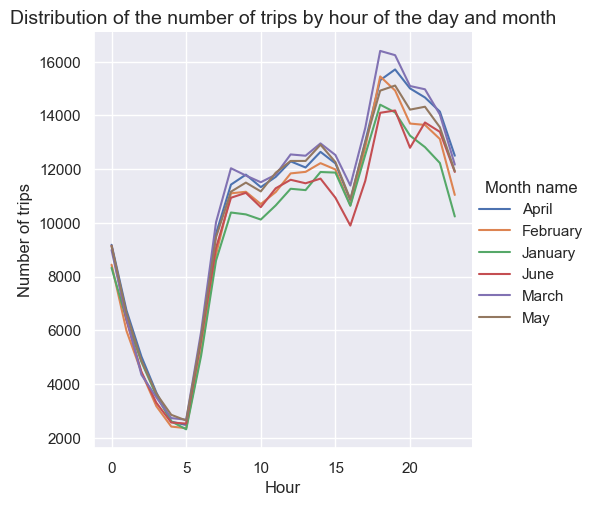

In [17]:
tmp_data = train.groupby(['month_name', 'hour']).id.count()\
.reset_index().rename({
    'month_name': 'Month name',
    'hour': 'Hour',
    'id': 'Number of trips'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Hour',
            y='Number of trips',
            hue='Month name',
            kind='line')
_ = plt.title('Distribution of the number of trips by hour of the day and month', dict(size=14))

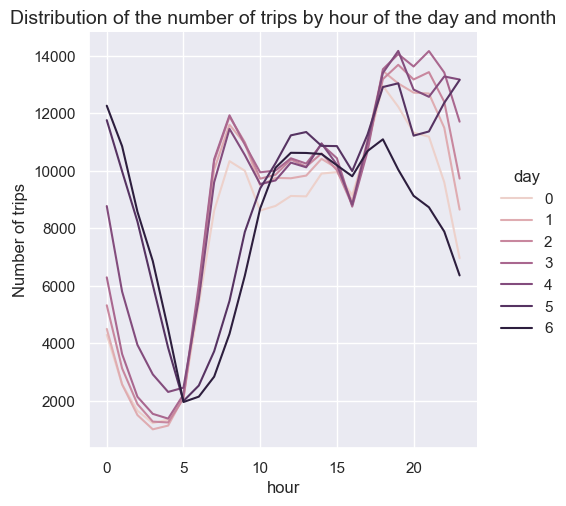

In [18]:
#your code for the dependence of the number of trips on the hour of the day for different days of the week is here:
tmp_data = train.groupby(['day_of_week', 'hour']).id.count()\
.reset_index().rename({
    'day_of_week': 'day',
    'hour': 'hour',
    'id': 'Number of trips'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='hour',
            y='Number of trips',
            hue='day',
            kind='line')
_ = plt.title('Distribution of the number of trips by hour of the day and month', dict(size=14))

**Question**: What conclusions can be drawn based on the graphs above? Are there any special days of the week? Months? Times of Day? What is it connected with?

**Answer**: We can see from the graphs what in the very early hours like 5-6 am where is kind of low number of trips, so the pick of the graphs is from 15 to 20. In interesting point what in monday is the lowest and the highest on thursday. It's actually kind of normal thing what in early morning nobody works and in the midday and evening the highest demand on taxi

**Task 4**. Split the sample into train and test (7:3). For the train sample, plot the mean logarithm of travel time versus day of the week. Then do the same, but for the hour of the day and the day of the year.

Add the following traits based on `pickup_datetime`:
1. Day of the week
2. Month
3. Hour
4. Is the period anomalous (two binary signs corresponding to two anomalous periods)
5. Number of the day in the year

In [19]:
train = train.drop('month_name', axis=1)
train['month'] = train.pickup_datetime.dt.month

train['is_anomaly_jan'] = ((23 <= train.day_of_year) & (train.day_of_year <= 26)).astype('int')
train['is_anomaly_may'] = (train.day_of_year == 151).astype('int')

In [20]:
#your code for splitting is here:
train_data, test_data = train_test_split(train, test_size=0.3)
#end of ypur code

In [21]:
display(train_data.sample(2))
test_data.sample(2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,day_of_year,hour,day_of_week,month,is_anomaly_jan,is_anomaly_may
1232009,id1068297,1,2016-06-17 23:00:45,4,-73.989601,40.758942,-74.003227,40.732670,N,6.867974,169,23,4,6,0,0
176753,id3268126,1,2016-01-08 20:18:35,1,-73.994415,40.741867,-73.886551,40.768597,N,7.391415,8,20,4,1,0,0


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,day_of_year,hour,day_of_week,month,is_anomaly_jan,is_anomaly_may
78914,id0386148,2,2016-02-20 13:40:41,2,-73.981216,40.767727,-73.989120,40.761341,N,6.839476,51,13,5,2,0,0
1337071,id0049316,1,2016-02-14 18:57:31,1,-74.003227,40.738705,-73.987335,40.762299,N,7.542744,45,18,6,2,0,0


In [22]:
tmp_data

,day,hour,Number of trips
0,0,0,4299
1,0,1,2578
2,0,2,1658
3,0,3,1226
4,0,4,1351
5,0,5,2147
6,0,6,5357
7,0,7,8620
8,0,8,10342
9,0,9,10007


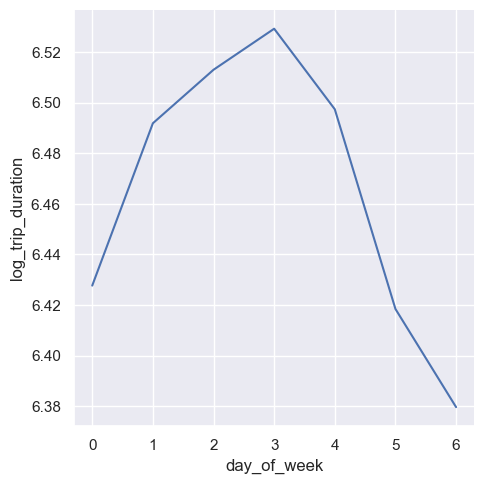

In [23]:
#your code for distribution of average trip duration by the number of day in a week is here:

tmp_data = train_data.groupby('day_of_week').log_trip_duration.mean().reset_index()
sns.relplot(data = tmp_data, x = 'day_of_week', y = 'log_trip_duration', kind = 'line')

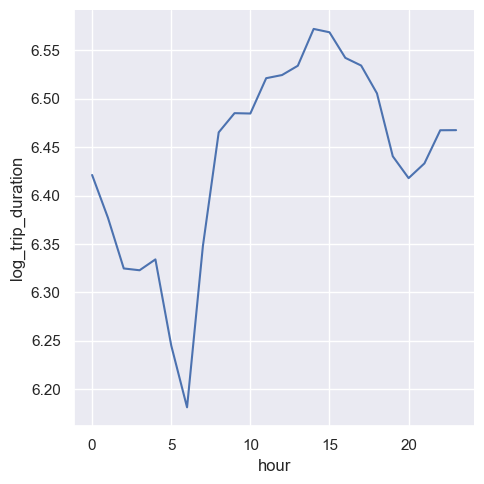

In [24]:
#your code for distribution of average trip duration by the hour of day is here:
tmp_data = train_data.groupby('hour').log_trip_duration.mean().reset_index()
sns.relplot(data = tmp_data, x = 'hour', y = 'log_trip_duration', kind = 'line')
#end of your code

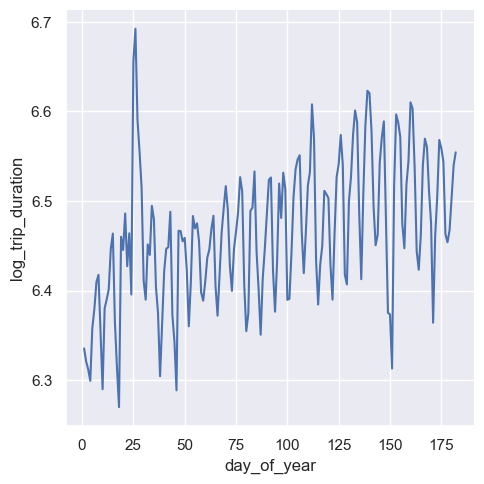

In [25]:
#your code for distribution of average trip duration by the number of day in the year is here:
tmp_data = train_data.groupby('day_of_year').log_trip_duration.mean().reset_index()
sns.relplot(data = tmp_data, x = 'day_of_year', y = 'log_trip_duration', kind = 'line')
#end of your code

**Question**: Are the graphs of the target depending on the day of the week and on the hour of the day similar to those for the number of trips? Why? What happens to the average target in those two anomalous periods that we saw above? Why is this happening? Do you see any trend in the plot of `log_trip_duration` versus day of the year?

**Answer**: Yes, absolutely roads are not in traffic jam so trip will be faster than in the midday and evening when traffic jams and a lot of cars in the road. So yeah not so much trips leads -> faster trips, and a great amount of trips -> longer ride in taxi. So, anomaly is the peak of trafic jam maybe sitution in the road was collapse, and so log trip will be higher. After this day log_trip is growing so maybe blizzard have influence in road

So, we have already created a number of features.

**Question**: Which of the features should be considered as categorical, and which - as numerical? Why?






**Answer**: numerical is passenger_count all coordinates, day_of_year, hour, month, vendor_id. Cat is store_and_fwd_flag. BTW id is not valuable feature so we drop it, becaues for our model we don't need to use id as a feature, because idendificator of trip don't give info to model

In [26]:
train

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,day_of_year,hour,day_of_week,month,is_anomaly_jan,is_anomaly_may
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,74,17,0,3,0,0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,164,0,6,6,0,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,19,11,1,1,0,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,97,19,2,4,0,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,86,13,5,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,N,6.658011,99,13,4,4,0,0
1458640,id1049543,1,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,N,6.486161,10,7,6,1,0,0
1458641,id2304944,2,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,N,6.639876,113,6,4,4,0,0
1458642,id2714485,1,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,N,5.924256,5,15,1,1,0,0


**Task 5**. Train `Ridge` regression with default parameters by encoding all categorical features with `OneHotEncoder`. Scale numerical features with `StandardScaler`. Use only the features that we have identified in this part of the task.

In [27]:
def make_pipeline(categorical, numeric, model):
    
    numeric_transformer = Pipeline(steps=[
          ('scaler', StandardScaler())
    ])
#your code for categorical transformer is here:  
    categorical_transformer = Pipeline(steps = [('ohe', OneHotEncoder())])
#end of ypur code
    preprocessor = ColumnTransformer(
       transformers=[
        ('numeric', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical),
    ])
    
    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    return pipeline

def fit_pipeline(pipeline, train_data, test_data):    
#your code to is here:  
    X_train = train_data.drop(target, axis=1)
    y_train = train_data[target]
    pipeline.fit(X_train, y_train)
#end of your code

    print('Train RMSE is {}'.format(RMSE(train_data[target], pipeline.predict(train_data.drop(target, axis=1)))))
    print('Test RMSE is {}'.format(RMSE(test_data[target], pipeline.predict(test_data.drop(target, axis=1)))))

In [28]:
train = train.drop('id', axis=1)

In [29]:
#your list of categorical features is here:
categorical_columns = list(train.dtypes[train_.dtypes == "object"].index)
#your list of numerical features is here:
numeric_columns = train.select_dtypes(include='number').columns
numeric_columns = numeric_columns.drop('log_trip_duration')
#your code to create pipeline is here:
pipeline = make_pipeline(categorical=categorical_columns, numeric=numeric_columns, model = Ridge())
#end of ypur code
fit_pipeline(pipeline, *train_test_split(train, random_state=42, test_size=0.3))

Train RMSE is 0.7773213565788242
Test RMSE is 0.7782633501010766


In [30]:
display(categorical_columns)
numeric_columns

['store_and_fwd_flag']

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'day_of_year', 'hour',
       'day_of_week', 'month', 'is_anomaly_jan', 'is_anomaly_may'],
      dtype='object')

**Task 6**. Try to use any other way of categorical features encoding and normalization for numerical features. Train `Ridge` and `Lasso` regression for various encoding options and evaluate the results. Which one turned out to be the best? Why did other options show worse quality?

In [36]:
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder,StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans


def make_pipeline(categorical, numeric, model, cat_encoder, num_scaler):
    numeric_transformer = Pipeline(steps=[
            ('scaler', num_scaler)
    ])
    #your code for categorical transformer is here:  
    categorical_transformer = Pipeline(steps=[
        ('CE', cat_encoder)
    ])
    #end of ypur code
    preprocessor = ColumnTransformer(
        transformers=[
        ('numeric', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical),
    ])

    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    return pipeline

models = [Ridge(), Lasso()]
numeric_scaler = [StandardScaler(), MinMaxScaler(), RobustScaler(), KMeans(n_clusters=4)]
categorical_encoders = [OneHotEncoder(), OrdinalEncoder(), ce.TargetEncoder()]

for model in models:
    for num_scal in numeric_scaler:
        for cat_enc in categorical_encoders:
            pipeline = make_pipeline(categorical=categorical_columns, 
                            numeric=numeric_columns, model = model, cat_encoder = cat_enc,
                            num_scaler = num_scal
                            )
            print(f'Model is {model}, numerical scaler is {num_scal} and categorical scaler is {cat_enc}')
            fit_pipeline(pipeline, *train_test_split(train, random_state=42, test_size=0.3))

Model is Ridge(), numerical scaler is StandardScaler() and categorical scaler is OneHotEncoder()
Train RMSE is 0.7773213565788242
Test RMSE is 0.7782633501010766
Model is Ridge(), numerical scaler is StandardScaler() and categorical scaler is OrdinalEncoder()
Train RMSE is 0.7773213565807032
Test RMSE is 0.778263349649846
Model is Ridge(), numerical scaler is StandardScaler() and categorical scaler is TargetEncoder()
Train RMSE is 0.7773213598288511
Test RMSE is 0.7782633211484681
Model is Ridge(), numerical scaler is MinMaxScaler() and categorical scaler is OneHotEncoder()
Train RMSE is 0.7785310685773039
Test RMSE is 0.7780128941575412
Model is Ridge(), numerical scaler is MinMaxScaler() and categorical scaler is OrdinalEncoder()
Train RMSE is 0.7785310680643378
Test RMSE is 0.7780128928113815
Model is Ridge(), numerical scaler is MinMaxScaler() and categorical scaler is TargetEncoder()
Train RMSE is 0.7785310356093579
Test RMSE is 0.778012802003811
Model is Ridge(), numerical scaler

Lasso keeps giving worse results it show us that all features makes sense. because the thing for lasso that it gives 0 coeff to feature which impact is low, so all Ridge according for rmse gives better results

Ridge is better if we use minmax scaler, it also not so far from other numerical scalers but it's better than any other. In case of categorical yes ordinal is better but not so much then OHE. So min max scale in default in range 0 to 1 which is kind of similar to mean 0, std 1, so this method helps us to get better result

**Task 7**. Split the training sample into train and validation (8:2). On the validation set, find the optimal values of the regularization parameter (on a logarithmic grid) for `Ridge` and `Lasso`, measure the quality of the best obtained model on the test set.

In [43]:
from sklearn.model_selection import GridSearchCV
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder,StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans


def make_pipeline(categorical, numeric, model, cat_encoder, num_scaler):
    numeric_transformer = Pipeline(steps=[
            ('scaler', num_scaler)
    ])
    #your code for categorical transformer is here:  
    categorical_transformer = Pipeline(steps=[
        ('CE', cat_encoder)
    ])
    #end of ypur code
    preprocessor = ColumnTransformer(
        transformers=[
        ('numeric', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical),
    ])

    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regression', model)
    ])
    return pipeline

def find_alpha(pipeline, train_data, test_data):    
#your code to is here:  
    alphas = np.logspace(-2, 3, 20)
    searcher = GridSearchCV(pipeline, [{"regression__alpha": alphas}],scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
    X_train = train_data.drop(target, axis=1)
    y_train = train_data[target]
    searcher.fit(X_train, y_train)
    print(searcher.best_params_["regression__alpha"])
    return searcher.best_params_["regression__alpha"]



numeric_scaler = [StandardScaler(), MinMaxScaler(), RobustScaler(), KMeans(n_clusters=3)]
categorical_encoders = [OneHotEncoder(), OrdinalEncoder(), ce.TargetEncoder()]


for num_scal in numeric_scaler:
    for cat_enc in categorical_encoders:
        pipeline = make_pipeline(categorical=categorical_columns, 
                        numeric=numeric_columns, model = Ridge(), cat_encoder = cat_enc,
                        num_scaler = num_scal
                        )
        best_alpha = find_alpha(pipeline, *train_test_split(train, random_state=42, test_size=0.2))
        pipeline_with_best_alpha = make_pipeline(categorical=categorical_columns, 
                        numeric=numeric_columns, model = Ridge(best_alpha), cat_encoder = cat_enc,
                        num_scaler = num_scal
                        )
        print(f'Model is Ridge, numerical scaler is {num_scal} and categorical scaler is {cat_enc}')
        fit_pipeline(pipeline_with_best_alpha, *train_test_split(train, random_state=42, test_size=0.2))

1000.0
Model is Lasso(alpha=1000.0), numerical scaler is StandardScaler() and categorical scaler is OneHotEncoder()
Train RMSE is 0.7779109062001647
Test RMSE is 0.7759211539723315
1000.0
Model is Lasso(alpha=1000.0), numerical scaler is StandardScaler() and categorical scaler is OrdinalEncoder()
Train RMSE is 0.7779119718838622
Test RMSE is 0.7759204664574164
0.01
Model is Lasso(alpha=1000.0), numerical scaler is StandardScaler() and categorical scaler is TargetEncoder()
Train RMSE is 0.7779104211469948
Test RMSE is 0.7759205276879061
0.6951927961775606
Model is Lasso(alpha=1000.0), numerical scaler is MinMaxScaler() and categorical scaler is OneHotEncoder()
Train RMSE is 0.7784345317070596
Test RMSE is 0.777320933527808
0.6951927961775606
Model is Lasso(alpha=1000.0), numerical scaler is MinMaxScaler() and categorical scaler is OrdinalEncoder()
Train RMSE is 0.7784345315177572
Test RMSE is 0.777320932004443
0.6951927961775606
Model is Lasso(alpha=1000.0), numerical scaler is MinMaxSc

KeyboardInterrupt: 

In [47]:
from sklearn.model_selection import GridSearchCV
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder,StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
### Now we are going to compare all models so lets start by doing DataFrame
def make_pipeline(categorical, numeric, model, cat_encoder, num_scaler):
    numeric_transformer = Pipeline(steps=[
            ('scaler', num_scaler)
    ])
    #your code for categorical transformer is here:  
    categorical_transformer = Pipeline(steps=[
        ('CE', cat_encoder)
    ])
    #end of ypur code
    preprocessor = ColumnTransformer(
        transformers=[
        ('numeric', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical),
    ])

    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regression', model)
    ])
    return pipeline

def find_alpha(pipeline, train_data, test_data):    
#your code to is here:  
    alphas = np.logspace(-2, 3, 20)
    searcher = GridSearchCV(pipeline, [{"regression__alpha": alphas}],scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
    X_train = train_data.drop(target, axis=1)
    y_train = train_data[target]
    searcher.fit(X_train, y_train)
    print(searcher.best_params_["regression__alpha"])
    return searcher.best_params_["regression__alpha"]

def fit_pipeline_with_res(pipeline, train_data, test_data):    
#your code to is here:  
    X_train = train_data.drop(target, axis=1)
    y_train = train_data[target]
    pipeline.fit(X_train, y_train)
    train_rmse = RMSE(train_data[target], pipeline.predict(train_data.drop(target, axis=1)))
    test_rmse = RMSE(test_data[target], pipeline.predict(test_data.drop(target, axis=1)))
    return train_rmse, test_rmse


numeric_scaler = [StandardScaler(), MinMaxScaler(), RobustScaler(), KMeans(n_clusters=4)]
categorical_encoders = [OneHotEncoder(), OrdinalEncoder(), ce.TargetEncoder()]
models = [Ridge(), Lasso()]


df = {'model':[], 'numeric_scaler' : [], 'categorical_encoder':[],
        'alpha':[], 'train_rmse':[], 'test_rmse':[]}

for model in models:
    for num_scal in numeric_scaler:
        for cat_enc in categorical_encoders:
            pipeline = make_pipeline(categorical=categorical_columns, 
                            numeric=numeric_columns, model = model, cat_encoder = cat_enc,
                            num_scaler = num_scal
                            )
            print(f'Model is {model}, numerical scaler is {num_scal} and categorical scaler is {cat_enc}')
            res = fit_pipeline_with_res(pipeline, *train_test_split(train, random_state=42, test_size=0.3))
            df['model'].append(str(model))
            df['numeric_scaler'].append(str(num_scal))
            df['categorical_encoder'].append(str(cat_enc))
            df['alpha'].append('Model without alpha search')
            df['train_rmse'].append(res[0])
            df['test_rmse'].append(res[1])

print(df)
for num_scal in numeric_scaler:
    for cat_enc in categorical_encoders:
        pipeline = make_pipeline(categorical=categorical_columns, 
                        numeric=numeric_columns, model = Ridge(), cat_encoder = cat_enc,
                        num_scaler = num_scal
                        )
        best_alpha = find_alpha(pipeline, *train_test_split(train, random_state=42, test_size=0.2))
        pipeline_with_best_alpha = make_pipeline(categorical=categorical_columns, 
                        numeric=numeric_columns, model = Ridge(best_alpha), cat_encoder = cat_enc,
                        num_scaler = num_scal
                        )
        print(f'Model is Ridge, numerical scaler is {num_scal} and categorical scaler is {cat_enc}')
        res = fit_pipeline_with_res(pipeline_with_best_alpha, *train_test_split(train, random_state=42, test_size=0.2))
        df['model'].append('Ridge()')
        df['numeric_scaler'].append(str(num_scal))
        df['categorical_encoder'].append(str(cat_enc))
        df['alpha'].append(best_alpha)
        df['train_rmse'].append(res[0])
        df['test_rmse'].append(res[1])

for num_scal in numeric_scaler:
    for cat_enc in categorical_encoders:
        pipeline = make_pipeline(categorical=categorical_columns, 
                        numeric=numeric_columns, model = Lasso(), cat_encoder = cat_enc,
                        num_scaler = num_scal
                        )
        best_alpha = find_alpha(pipeline, *train_test_split(train, random_state=42, test_size=0.2))
        pipeline_with_best_alpha = make_pipeline(categorical=categorical_columns, 
                        numeric=numeric_columns, model = Lasso(best_alpha), cat_encoder = cat_enc,
                        num_scaler = num_scal
                        )
        print(f'Model is Lasso, numerical scaler is {num_scal} and categorical scaler is {cat_enc}')
        res = fit_pipeline_with_res(pipeline_with_best_alpha, *train_test_split(train, random_state=42, test_size=0.2))
        df['model'].append('Lasso()')
        df['numeric_scaler'].append(str(num_scal))
        df['categorical_encoder'].append(str(cat_enc))
        df['alpha'].append(best_alpha)
        df['train_rmse'].append(res[0])
        df['test_rmse'].append(res[1])
df = pd.DataFrame(df)
df

Model is Ridge(), numerical scaler is StandardScaler() and categorical scaler is OneHotEncoder()
Model is Ridge(), numerical scaler is StandardScaler() and categorical scaler is OrdinalEncoder()
Model is Ridge(), numerical scaler is StandardScaler() and categorical scaler is TargetEncoder()
Model is Ridge(), numerical scaler is MinMaxScaler() and categorical scaler is OneHotEncoder()
Model is Ridge(), numerical scaler is MinMaxScaler() and categorical scaler is OrdinalEncoder()
Model is Ridge(), numerical scaler is MinMaxScaler() and categorical scaler is TargetEncoder()
Model is Ridge(), numerical scaler is RobustScaler() and categorical scaler is OneHotEncoder()
Model is Ridge(), numerical scaler is RobustScaler() and categorical scaler is OrdinalEncoder()
Model is Ridge(), numerical scaler is RobustScaler() and categorical scaler is TargetEncoder()
Model is Ridge(), numerical scaler is KMeans(n_clusters=4) and categorical scaler is OneHotEncoder()
Model is Ridge(), numerical scaler 

/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.

26.366508987303583
Model is Ridge, numerical scaler is KMeans(n_clusters=4) and categorical scaler is OneHotEncoder()


/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.

0.03359818286283781
Model is Ridge, numerical scaler is KMeans(n_clusters=4) and categorical scaler is OrdinalEncoder()


/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.

7.847599703514607
Model is Ridge, numerical scaler is KMeans(n_clusters=4) and categorical scaler is TargetEncoder()
0.01
Model is Lasso, numerical scaler is StandardScaler() and categorical scaler is OneHotEncoder()
0.01
Model is Lasso, numerical scaler is StandardScaler() and categorical scaler is OrdinalEncoder()
0.01
Model is Lasso, numerical scaler is StandardScaler() and categorical scaler is TargetEncoder()
0.01
Model is Lasso, numerical scaler is MinMaxScaler() and categorical scaler is OneHotEncoder()
0.01
Model is Lasso, numerical scaler is MinMaxScaler() and categorical scaler is OrdinalEncoder()
0.01
Model is Lasso, numerical scaler is MinMaxScaler() and categorical scaler is TargetEncoder()
0.01
Model is Lasso, numerical scaler is RobustScaler() and categorical scaler is OneHotEncoder()
0.01
Model is Lasso, numerical scaler is RobustScaler() and categorical scaler is OrdinalEncoder()
0.01
Model is Lasso, numerical scaler is RobustScaler() and categorical scaler is TargetEn

/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.

0.01
Model is Lasso, numerical scaler is KMeans(n_clusters=4) and categorical scaler is OneHotEncoder()


/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.

0.01
Model is Lasso, numerical scaler is KMeans(n_clusters=4) and categorical scaler is OrdinalEncoder()


/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dimafomin/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/cluster/_kmeans.

0.01
Model is Lasso, numerical scaler is KMeans(n_clusters=4) and categorical scaler is TargetEncoder()


,model,numeric_scaler,categorical_encoder,alpha,train_rmse,test_rmse
0,Ridge(),StandardScaler(),OneHotEncoder(),Model without alpha search,0.777321,0.778263
1,Ridge(),StandardScaler(),OrdinalEncoder(),Model without alpha search,0.777321,0.778263
2,Ridge(),StandardScaler(),TargetEncoder(),Model without alpha search,0.777321,0.778263
3,Ridge(),MinMaxScaler(),OneHotEncoder(),Model without alpha search,0.778531,0.778013
4,Ridge(),MinMaxScaler(),OrdinalEncoder(),Model without alpha search,0.778531,0.778013
5,Ridge(),MinMaxScaler(),TargetEncoder(),Model without alpha search,0.778531,0.778013
6,Ridge(),RobustScaler(),OneHotEncoder(),Model without alpha search,0.777321,0.778263
7,Ridge(),RobustScaler(),OrdinalEncoder(),Model without alpha search,0.777321,0.778263
8,Ridge(),RobustScaler(),TargetEncoder(),Model without alpha search,0.777321,0.778263
9,Ridge(),KMeans(n_clusters=4),OneHotEncoder(),Model without alpha search,0.794693,0.793680


In [51]:
df.sort_values('test_rmse')

,model,numeric_scaler,categorical_encoder,alpha,train_rmse,test_rmse
25,Ridge(),StandardScaler(),OrdinalEncoder(),1000.0,0.777912,0.775920
31,Ridge(),RobustScaler(),OrdinalEncoder(),26.366509,0.777910,0.775921
26,Ridge(),StandardScaler(),TargetEncoder(),0.01,0.777910,0.775921
32,Ridge(),RobustScaler(),TargetEncoder(),0.01,0.777910,0.775921
30,Ridge(),RobustScaler(),OneHotEncoder(),88.586679,0.777910,0.775921
24,Ridge(),StandardScaler(),OneHotEncoder(),1000.0,0.777911,0.775921
36,Lasso(),StandardScaler(),OneHotEncoder(),0.01,0.778616,0.777183
37,Lasso(),StandardScaler(),OrdinalEncoder(),0.01,0.778616,0.777183
38,Lasso(),StandardScaler(),TargetEncoder(),0.01,0.778616,0.777183
43,Lasso(),RobustScaler(),OrdinalEncoder(),0.01,0.779159,0.777316


So the best one is Ridge()	StandardScaler()	OrdinalEncoder() and it is better when the same model without regulatization with best alpha. Interesting moment that we get lasso in top ten with best alpha Lasso()	StandardScaler()	OneHotEncoder()

**Task 8**. Find data, which describes weather in New York during 2016 year. Add some features, based on this data and find new quality of your best model.

In [30]:
#your code is here


#end of your code

**Task 9**. Use information about start and end points of trip (with help of the function below (use small part of data) to create at least one new feature which will increase your quality. Study its correlation with the target, explain the results logically, test different encoding options and find your best quality.

In [31]:
# !pip install folium

In [32]:
import folium

ModuleNotFoundError: No module named 'folium'

In [ ]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [ ]:
show_circles_on_map(train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

In [ ]:
#your code is here


#end of your code